### Imports

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import seaborn as sns

sns.set_theme(style='ticks')
sns.set_context('paper')

# from pycaret.regression import *

In [2]:
# plot two features against each other
def plot_jointplot(data, x, y):
    r, p = sp.stats.pearsonr(data[x], data[y])

    jgrid = sns.jointplot(data=data, x=x, y=y, kind='reg')
    jgrid.ax_joint.text(
        1, 1, 
        f"r={r:.2f}, p={p:.2e}",
        horizontalalignment='right',
        transform = jgrid.ax_joint.transAxes
    )

    jgrid.figure.show()

In [3]:
data = gpd.read_file('../GENERATED-DATA/data_by_zone.geojson')
data.shape

(342, 78)

### Plots

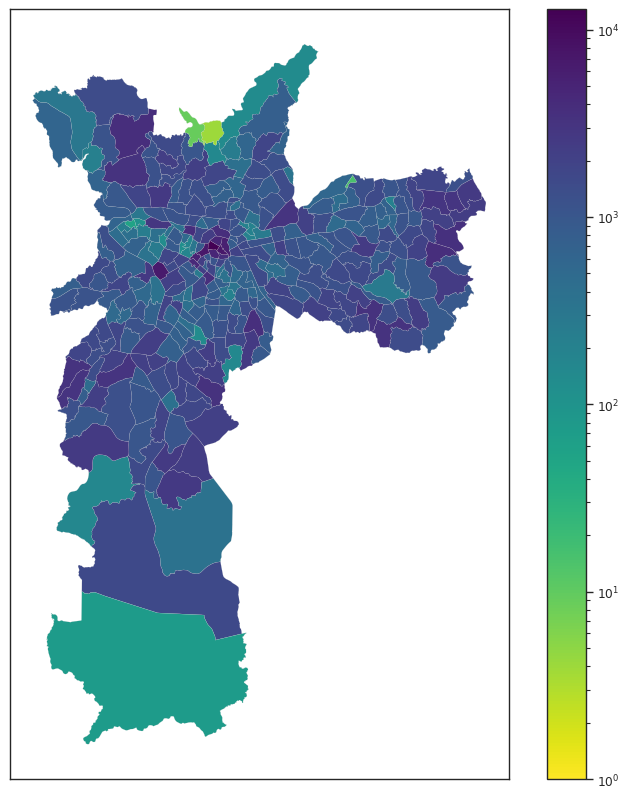

In [4]:
data.plot(
    column='crimes',
    legend=True,
    linewidth=0.1,
    edgecolor='0.8',
    figsize=(10, 10),
    cmap='viridis_r',
    norm=LogNorm(vmin=1, vmax=data['crimes'].max()),
)

plt.xticks([])
plt.yticks([])

plt.show()


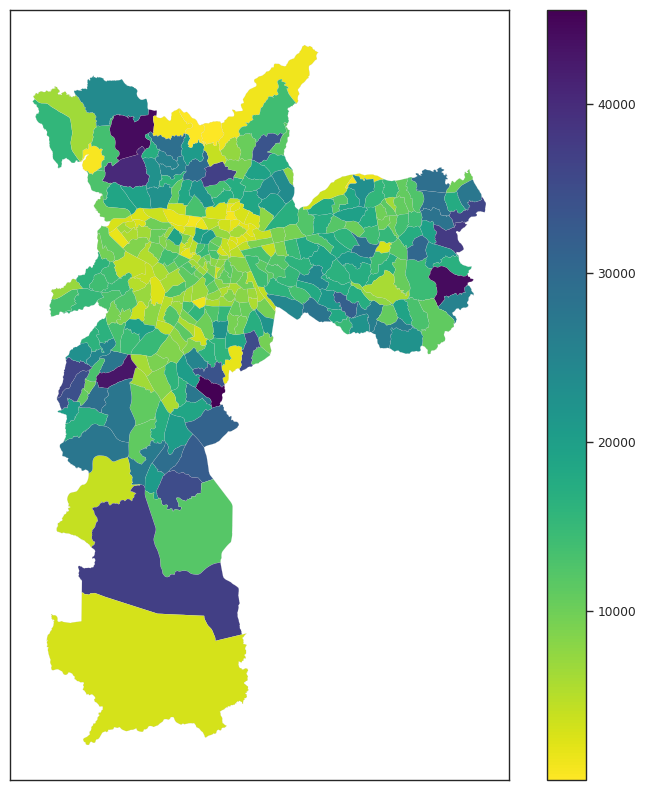

In [5]:
data.plot(
    column='V001_BASICO',
    legend=True,
    linewidth=0.1,
    edgecolor='0.8',
    figsize=(10, 10),
    cmap='viridis_r',
)

plt.xticks([])
plt.yticks([])

plt.show()


### Regression

In [6]:
data.dropna(inplace=True)
data.shape

(338, 78)

In [7]:
features_to_drop = [
    'NumeroZona',
    'NomeZona',
    'NumeroMuni',
    'NomeMunici',
    'NumDistrit',
    'NomeDistri',
    'geometry',
    'crimes',
]

features = [feature for feature in data.columns.to_list() if feature not in features_to_drop]
data = data[features + ['crimes']]
data.shape

(338, 71)

### Exploring the connection between crime and other variables

#### CENSUS Variables

In [8]:
df = data[[
    'Area_ha_2', 'V001_ENTORNO01', 'V002_ENTORNO01', 'V003_ENTORNO01',
    'V004_ENTORNO01', 'V001_DOMICILIORENDA', 'V001_BASICO', 'V002_BASICO',
    'V001_DOMICILIO02', 'V002_DOMICILIO02', 'V001_DOMICILIO01',
    'V002_DOMICILIO01', 'V001_PESSOA01', 'V086_PESSOA02', 'V001_PESSOA03',
    'V002_PESSOA03', 'V003_PESSOA03', 'V004_PESSOA03', 'V005_PESSOA03',
    'V006_PESSOA03', 'V001_PESSOA12', 'V001_PESSOA11', 'V001_RESPONSAVEL01',
    'V001_RESPONSAVEL02', 'V002_DOMICILIORENDA', 'V003_DOMICILIORENDA',
    'V004_DOMICILIORENDA', 'V003_BASICO', 'V005_BASICO', 'V007_BASICO',
    'V009_BASICO', 'V011_BASICO', 'crimes'
]]

df.shape

(338, 33)

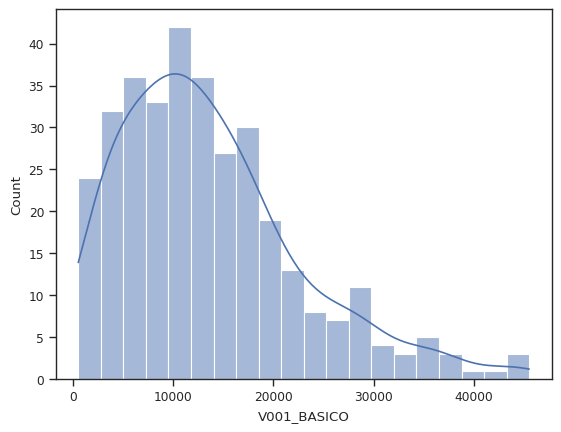

In [9]:
ax = sns.histplot(data=df, x='V001_BASICO', bins=20, kde=True)

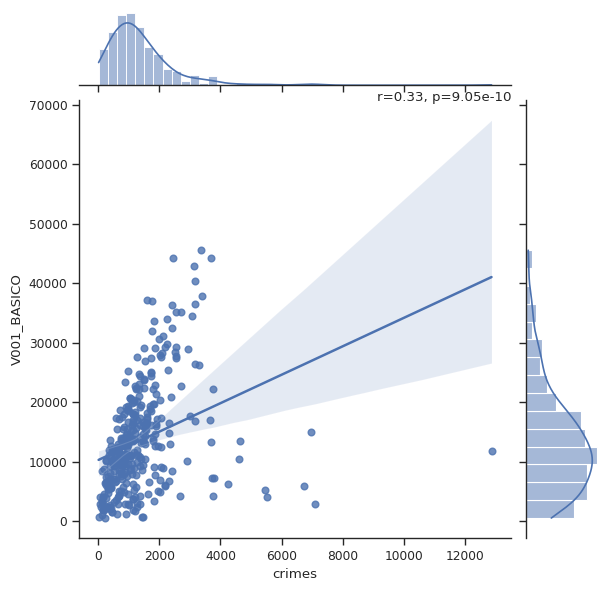

In [10]:
plot_jointplot(df, 'crimes', 'V001_BASICO')

<Axes: xlabel='crimes'>

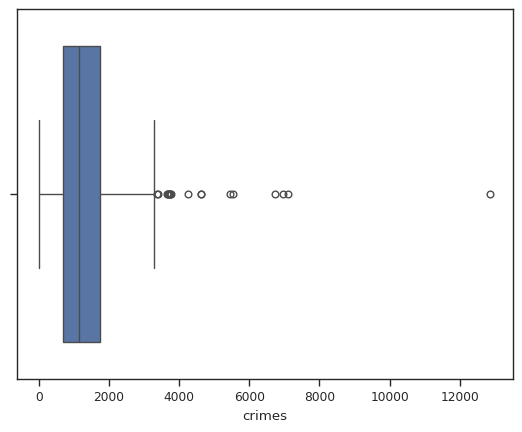

In [11]:
sns.boxplot(data=df, x='crimes')

In [12]:
# remove outliers based on the IQR
Q1 = df['crimes'].quantile(0.25)
Q3 = df['crimes'].quantile(0.75)
IQR = Q3 - Q1

df = df[~((df['crimes'] < (Q1 - 1.5 * IQR)) | (df['crimes'] > (Q3 + 1.5 * IQR)))]

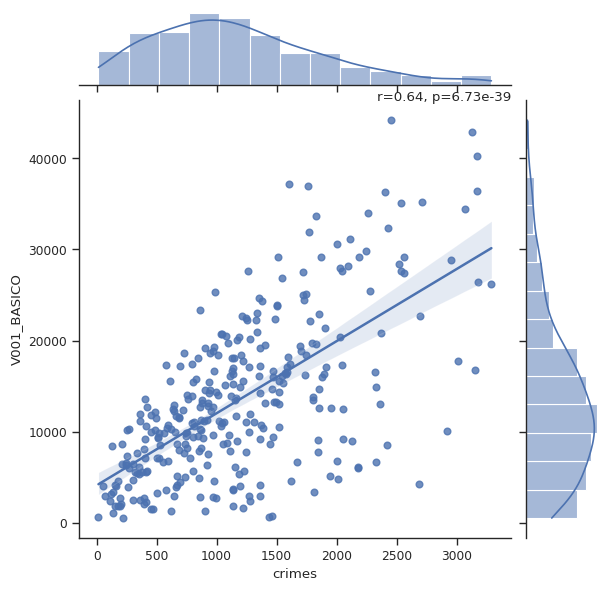

In [13]:
plot_jointplot(df, 'crimes', 'V001_BASICO')

In [14]:
# calcular pearson r for all features
corr_matrix = df.corr().abs()

# show as dataframe
corr_matrix['crimes'].sort_values(ascending=False).to_frame()[:10]

,crimes
crimes,1.000000
V001_DOMICILIO01,0.645286
V001_RESPONSAVEL02,0.644804
V002_DOMICILIO01,0.644135
V001_ENTORNO01,0.644135
V001_BASICO,0.644135
V001_RESPONSAVEL01,0.642564
V086_PESSOA02,0.638032
V001_PESSOA01,0.636880
V001_PESSOA03,0.635256


In [15]:
# it seems to be a lot of multicollinearity with V001_BASICO
# Domicílios particulares permanentes ou pessoas responsáveis por domicílios particulares permanentes

corr_matrix['V001_BASICO'].sort_values(ascending=False).to_frame()[:10]

,V001_BASICO
V001_ENTORNO01,1.000000
V002_DOMICILIO01,1.000000
V001_BASICO,1.000000
V001_RESPONSAVEL02,0.999985
V001_DOMICILIO01,0.999756
V001_PESSOA01,0.994071
V001_PESSOA12,0.992527
V001_RESPONSAVEL01,0.992402
V086_PESSOA02,0.991135
V001_PESSOA03,0.989741


In [16]:
df = df.loc[:, (df.columns == 'V001_BASICO') | (corr_matrix['V001_BASICO'] < 0.8)]

In [17]:
# calcular pearson r for all features
corr_matrix = df.corr().abs()

# show as dataframe
corr_matrix['crimes'].sort_values(ascending=False).to_frame()[:10]

,crimes
crimes,1.000000
V001_BASICO,0.644135
V003_ENTORNO01,0.331328
V002_DOMICILIORENDA,0.279409
V003_DOMICILIORENDA,0.279287
V005_BASICO,0.262166
V007_BASICO,0.257443
V011_BASICO,0.255587
V009_BASICO,0.255210
V006_PESSOA03,0.234571


<Axes: >

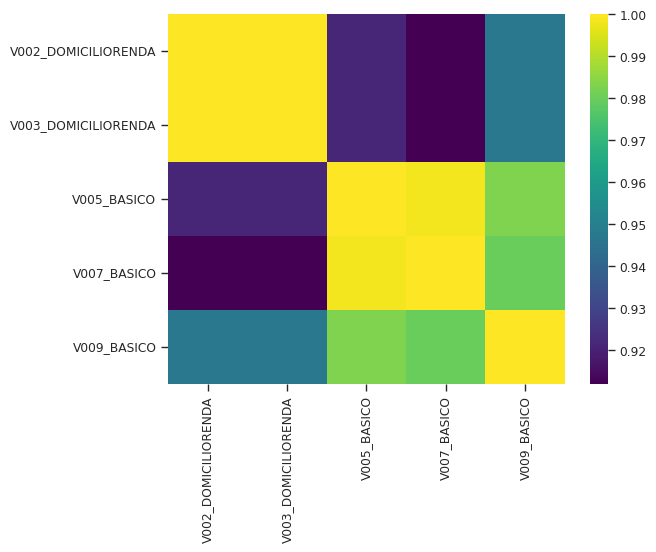

In [18]:
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

cols = (corr_matrix.mask(mask) > .8).any()
sns.heatmap(corr_matrix.loc[cols, cols], cmap='viridis')

In [19]:
# calcular pearson r for all features
corr_matrix = df.corr().abs()

# show as dataframe
corr_matrix['V005_BASICO'].sort_values(ascending=False).to_frame()[:10]

,V005_BASICO
V005_BASICO,1.000000
V007_BASICO,0.998299
V011_BASICO,0.991890
V009_BASICO,0.983010
V003_DOMICILIORENDA,0.921244
V002_DOMICILIORENDA,0.921208
V003_BASICO,0.664677
V003_ENTORNO01,0.396441
V001_BASICO,0.383068
crimes,0.262166


In [20]:
df = df.loc[:, (df.columns == 'V005_BASICO') | (corr_matrix['V005_BASICO'] < 0.8)]

In [21]:
df.columns

Index(['Area_ha_2', 'V003_ENTORNO01', 'V001_DOMICILIORENDA', 'V001_BASICO',
       'V004_PESSOA03', 'V006_PESSOA03', 'V004_DOMICILIORENDA', 'V003_BASICO',
       'V005_BASICO', 'crimes'],
      dtype='object')

In [22]:
from tpot import TPOTRegressor
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='crimes'), df['crimes'],
                                                    train_size=0.75, test_size=0.25, random_state=42)

tpot = TPOTRegressor(generations=5, population_size=50, verbosity=2, random_state=42)
tpot.fit(X_train, y_train)
print(tpot.score(X_test, y_test))

                                                                              
Generation 1 - Current best internal CV score: -281805.53512715024
                                                                              
Generation 2 - Current best internal CV score: -280253.5800638273
                                                                              
Generation 3 - Current best internal CV score: -280253.5800638273
                                                                              
Generation 4 - Current best internal CV score: -280253.5800638273
                                                                              
Generation 5 - Current best internal CV score: -277916.9541036828
                                                                              
Best pipeline: LinearSVR(MinMaxScaler(input_matrix), C=25.0, dual=False, epsilon=0.0001, loss=squared_epsilon_insensitive, tol=0.001)
-314048.0153205579


### PyCaret

In [311]:
data = df

In [ ]:
reg1 = setup(
    data = data,
    target = 'crimes',
    train_size = 0.8,

    # remove_multicollinearity = True,

    #normalize = True,
    #normalize_method = 'zscore',

    #transformation = True,
    #transformation_method = 'yeo-johnson',

    #transform_target = True,
    #transform_target_method='yeo-johnson',

    #remove_outliers = True,

    #feature_selection = True,
    #feature_selection_method = 'univariate',
    #n_features_to_select = 20,
    #feature_selection_estimator = 'rf',

    #fold_strategy = cv,

    verbose = True,
    session_id = 123,
)

In [ ]:
best = compare_models()

### Add Spacial Lag

In [ ]:
from pysal.lib import weights

knn = weights.KNN.from_dataframe(data, k=5) # k=5 -> 50%
wq  = weights.contiguity.Rook.from_dataframe(data)
w_kernel = weights.distance.Kernel.from_dataframe(data)

In [ ]:
f, axs = plt.subplots(figsize=(10, 10))

ax = data.plot(
    edgecolor="k", facecolor="w", ax=axs
)

knn.plot(
    data,
    ax=axs,
    edge_kws=dict(color="r", linestyle=":", linewidth=1),
    node_kws=dict(marker="")
)

axs.axis([-46.6, -46.8, -23.7, -23.6]);
axs.set_axis_off()

In [ ]:
gdf_lag = (
    data[features]
    .apply(
        lambda y: weights.spatial_lag.lag_spatial(wq, y)
    )
    .rename(
        columns=lambda c: "LAG_" + c
    )
)

In [ ]:
gdf_lag.shape

In [ ]:
gdf_lag.isna().sum()

In [ ]:
# data = data[features + ['crimes']].join(gdf_lag)
# data.columns